# 0. Imports and Fuctions

In [81]:
import boruta
import joblib
import warnings
import inflection

import numpy             as np
import pandas            as pd
import seaborn           as sns
import category_encoders as ce

import sklearn.metrics   as m
import matplotlib.pyplot as plt

from IPython.display      import Image
from IPython.core.display import HTML

from scipy    import stats
from boruta   import BorutaPy
from xgboost  import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm             import SVC
from sklearn.dummy           import DummyClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression

from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV 

## 0.1 Helper Functions

In [82]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    

def calcCramerV(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))


def ml_scores(model_name, y_true, y_pred):
    
    accuracy = m.balanced_accuracy_score(y_true, y_pred)
    precision = m.precision_score(y_true, y_pred)
    recall = m.recall_score(y_true, y_pred)
    f1 = m.f1_score(y_true, y_pred)
    kappa = m.cohen_kappa_score(y_true, y_pred)
    
    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3), 
                         'Precision': np.round(precision, 3), 
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         'Kappa': np.round(kappa, 3)}, index=[model_name])


def ml_cv_results(model_name, model, X, y):

    '''initial'''
    X_ = X.to_numpy()
    y_ = y.to_numpy()
    
    mm = MinMaxScaler()
    
    balanced_accuracies = []
    precisions = []
    recalls = []
    f1s = []
    kappas = []

    '''cross-validation'''
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    
    for index_train, index_test in skf.split(X_, y_):
       
        ## selecting train and test
        X_train, X_test = X.iloc[index_train], X.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]
        
        ## applying the scale
        X_train_rescaled = mm.fit_transform(X_train)
        X_test_rescaled = mm.transform(X_test)
        
        ## training the model
        model.fit(X_train_rescaled, y_train)
        y_pred = model.predict(X_test_rescaled)

        ## saving the metrics
        balanced_accuracies.append(m.balanced_accuracy_score(y_test, y_pred))
        precisions.append(m.precision_score(y_test, y_pred))
        recalls.append(m.recall_score(y_test, y_pred))
        f1s.append(m.f1_score(y_test, y_pred))
        kappas.append(m.cohen_kappa_score(y_test, y_pred))
        
    '''results'''    
    accuracy_mean, accuracy_std = np.round(np.mean(balanced_accuracies), 3), np.round(np.std(balanced_accuracies), 3)
    precision_mean, precision_std = np.round(np.mean(precisions), 3), np.round(np.std(precisions), 3)
    recall_mean, recall_std = np.round(np.mean(recalls), 3), np.round(np.std(recalls), 3)
    f1_mean, f1_std = np.round(np.mean(f1s), 3), np.round(np.std(f1s), 3)
    kappa_mean, kappa_std = np.round(np.mean(kappas), 3), np.round(np.std(kappas), 3)
    
    ## saving the results in a dataframe
    return pd.DataFrame({"Balanced Accuracy": "{} +/- {}".format(accuracy_mean, accuracy_std),
                        "Precision": "{} +/- {}".format(precision_mean, precision_std),
                        "Recall": "{} +/- {}".format(recall_mean, recall_std),
                        "F1": "{} +/- {}".format(f1_mean, f1_std),
                        "Kappa": "{} +/- {}".format(kappa_mean, kappa_std)},
                       index=[model_name])

In [3]:
jupyter_settings() 

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
df = pd.read_csv("datas/churn.csv")

# 1. Data Describe

In [5]:
df1 = df.copy()

In [6]:
df1.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## 1.1 Rename Columns

**EXPLICAÇÃO DAS COLUNAS** <br>

* RowNumber: O número da coluna
* CustomerID: Identificador único do cliente
* Surname: Sobrenome do cliente.
* CreditScore: A pontuação de Crédito do cliente para o mercado de consumo.
* Geography: O país onde o cliente reside.
* Gender: O gênero do cliente.
* Age: A idade do cliente.
* Tenure: Número de anos que o cliente permaneceu ativo.
* Balance: Valor monetário que o cliente tem em sua conta bancária.
* NumOfProducts: O número de produtos comprado pelo cliente no banco.
* HasCrCard: Indica se o cliente possui ou não cartão de crédito.
* IsActiveMember: Indica se o cliente fez pelo menos uma movimentação na conta bancário dentro de 12 meses.
* EstimateSalary: Estimativa do salário mensal do cliente.
* Exited: Indica se o cliente está ou não em Churn.

In [7]:
cols_old = ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure' ,'Balance', 'NumOfProducts', 
            'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [8]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 10000
Number of Cols: 14


## 1.3 Data Types 

In [9]:
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.5 Change DataTypes

In [11]:
df1['exited'] = df1['exited'].map({1: 'yes', 0: 'no'})
df1['is_active_member'] = df1['is_active_member'].map({1: 'yes', 0: 'no'})
df1['has_cr_card'] = df1['has_cr_card'].map({1: 'yes', 0: 'no'})

## 1.6 Descriptive Statistics

In [12]:
num_attributes = df1.select_dtypes(exclude='object')
cat_attributes = df1.select_dtypes(include='object')

### 1.6.1 Numerical Atributes

In [13]:
num_attributes = num_attributes.drop(columns=['row_number', 'customer_id'], axis=1) 

describe = num_attributes.describe().T

describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['variation coefficient'] = (num_attributes.std() / num_attributes.mean()).tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()

describe

,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis
credit_score,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00,500.00,0.148577,-0.071607,-0.425726
age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00,74.00,0.269458,1.011320,1.395347
tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00,10.00,0.576958,0.010991,-1.165225
balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09,250898.09,0.815803,-0.141109,-1.489412
num_of_products,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00,3.00,0.380117,0.745568,0.582981
estimated_salary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48,199980.90,0.574586,0.002085,-1.181518


**credit score** <br>
* coeficiente menor do que 15% dados homogêneos
* skew ligeiramente negativo pequena concentração para valores maiores

<br> 

**age**
* skew positivo concentração de dados para valores mais altos 
* range de 74 valores
* menor idade em 18 anos 

<br> 

**tenure**
* Número de anos médio de 5 anos 
* coeficiente de variação em 57% alta dispersão de dados 
* valor máximo 10 anos (pode ter algo limitante - começo da empresa) 

<br> 

**balance**
* coeficiente de variação muito alto 87% valores heterogêneos
* desvio padrão muito alto
* skew negativo concentração para valores mais altos
- Mostra uma discrepancia entre valores ganhos da 10000 amostras


<br> 

**num_of_products**
* dispersão dentro da média 
* máximo de produtos 4 

<br>

**estimated_salary**
* desvio padrão maior do que 50% alta dispersão de dados
* skew - baixo porém positivo tendendo a valores baixos (salários menores)


## 1.6.2 Categorical Atributes

In [14]:
cat_attributes['geography'].value_counts(normalize=True) 

France     0.5014
Germany    0.2509
Spain      0.2477
Name: geography, dtype: float64

In [15]:
cat_attributes['gender'].value_counts(normalize=True) 

Male      0.5457
Female    0.4543
Name: gender, dtype: float64

In [16]:
cat_attributes['is_active_member'].value_counts(normalize=True) 

yes    0.5151
no     0.4849
Name: is_active_member, dtype: float64

In [17]:
cat_attributes['exited'].value_counts(normalize=True) 

no     0.7963
yes    0.2037
Name: exited, dtype: float64

**INTEPRETAÇÃO**
* 50% dos clientes moram na França 
* Gênero está quase equiparável uma diferença de quase 6 p.p para masculinos 
* 51% não movimentaram a conta bancária nos últimos 12 meses 
* 20% saíram da empresa por algum motivo -> não estão mais ativos 

# 2.  Feature Engineering e Hipóteses

In [18]:
df2 = df1.copy()

## 2.1 Mapa Mental para Hipóteses

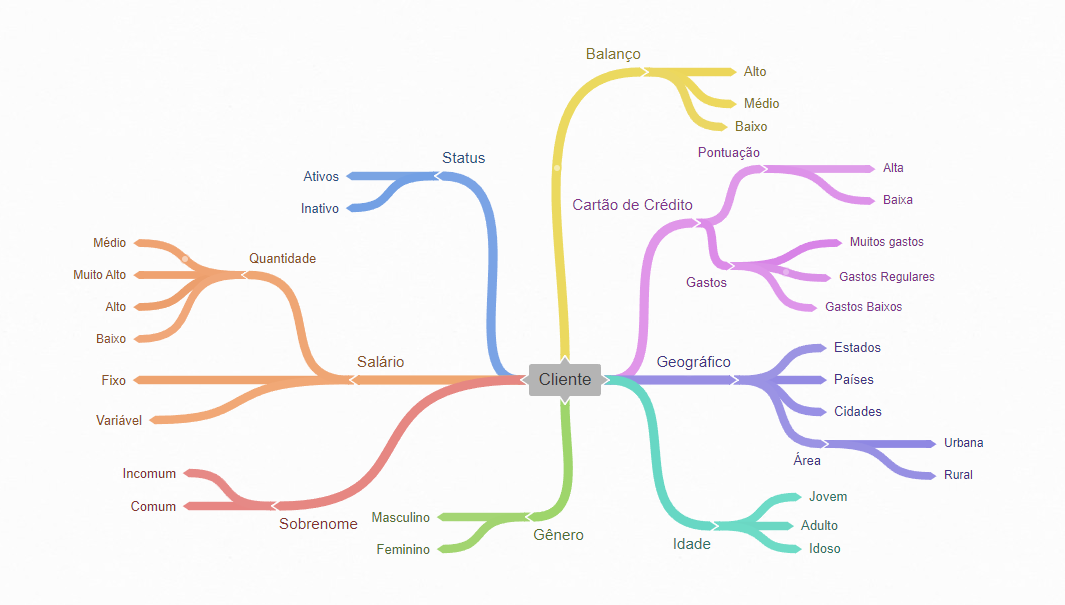

In [19]:
Image("datas/map.png") 

## 2.2 Criação de Hipótese

### 2.2.1 Hipótese Gênero

1. Mulheres desistem mais do que os homens
2. Temos mais homens ativos do que mulheres 
3. Existem mais homens idosos no churn
4. Homens com salários mais altos tem mais churn

### 2.2.2 Active Member 

1. Há mais pessoas jovens ativas do que pessoas idosas
2. Clientes ativos ganham mais 
3. Clientes ativos tem mais pontos no cartão de crédito
4. Clientes com salários mais altos são mais ativos 
5. Pessoas ativas compram mais produtos "NumOfProducts"

### 2.2.3 Credit Card

1. Pessoas mais jovens tem menor pontuação no cartão de crédito

### 2.2.4 Exited

1. Pessoas mais jovens que entram em churn.
2. Pessoas com menos crédito entram em churn
3. Pessoas que moram na Germany entram em mais churn quando comparado a Espanha
4. Pesssoas com Credit Score baixo entram em churn


## 2.3 Lista Final de Hipóteses 

**As 10 Hipóteses finais foram:**

1. Mulheres desistem mais do que os homens
2. Temos mais homens ativos do que mulheres 
3. Existem mais homens idosos no churn
4. Homens com salários mais altos tem mais churn
5. Clientes ativos ganham mais 
6. Clientes ativos tem mais ontos no cartão de crédito
7. Pessoas ativas compram mais produtos "NumOfProducts"
8. Clientes com Balance Alto tem churn mais alto
9. Pesssoas com Credit Score baixo entram em churn
10. Pessoas com idade mais nova entram jovens do que os idosos e os adultos

## 2.4 Feature Engineering 

In [20]:
#idade     (jovem, adulto, idoso)
df2["life_stage"] = df2["age"].apply( lambda x: "jovem" if x < 25 else "adulto" if (x > 25) & (x < 60) else "idoso")

In [21]:
#salários  (alto, médio, baixo)
df2["salary"] = df2["estimated_salary"].apply(lambda x: "baixo" if x < 51002.11 else "medio" if (x > 51002.11) & (x < 100193.915) else "alto" )

In [22]:
#pontuação (alta, baixa)
df2["pontuation"] = df2["credit_score"].apply(lambda x: "baixo" if x < 652.000 else "alto")

In [23]:
# balance (alto, baixo)
df2["valor"] = df2["balance"].apply(lambda x: "baixo" if x < 97198.540 else "alto")

In [24]:
df2['ranked_richest_eu'] = df2['geography'].map({'France': 14, 'Spain': 16, 'Germany': 8}) 

# 3. Filtering Variables

In [25]:
df3 = df2.copy() 

## 3.1 Filtering Lines

Não é necessário

## 3.2 Filtering Columns

As colunas de row_number, customer_id, surname - são colunas sobre referência ao consumidor são indiferentes para o nosso controle de dados

In [26]:
df3 = df3.drop(columns=['row_number', 'customer_id', 'surname'], axis=1) 

# 4. Exploratory Data Analysis

In [27]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

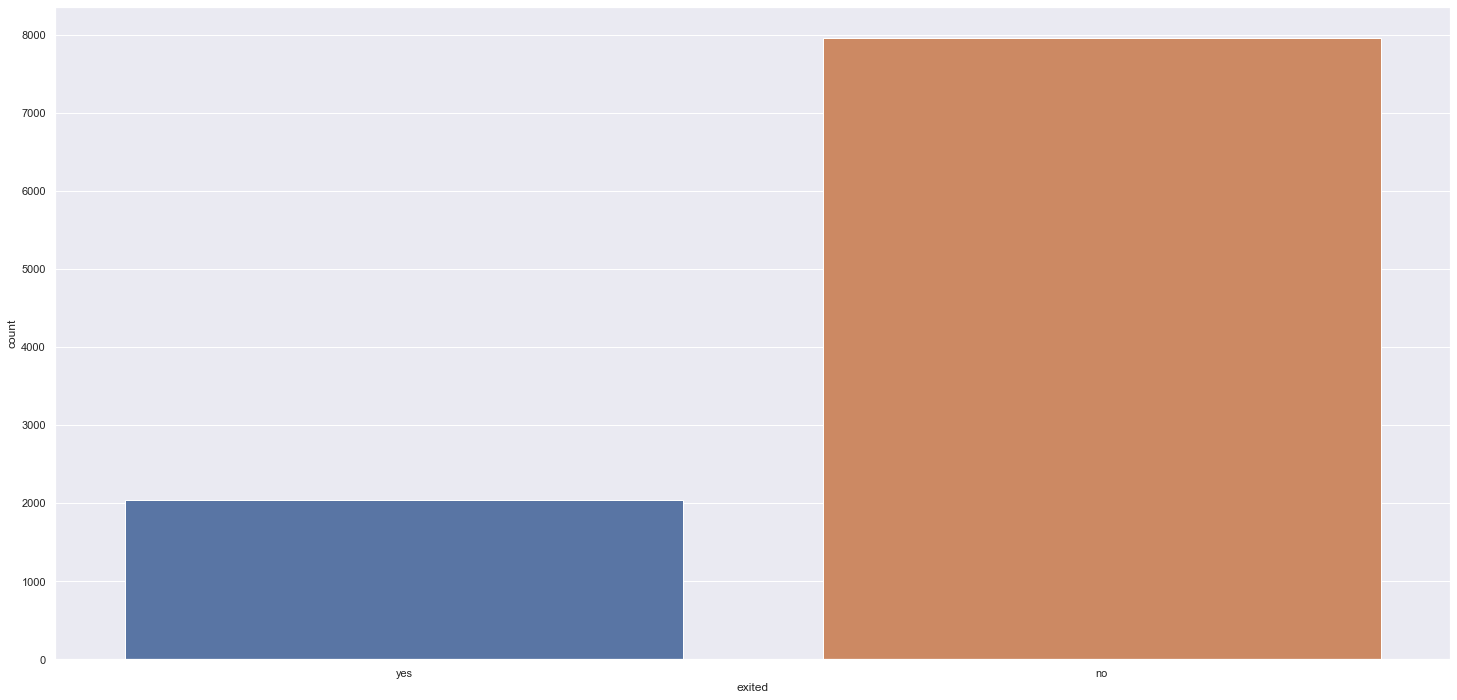

In [28]:
sns.countplot(x="exited", data=df4);

Temos uma grande maioria de dados como "no" do que pessoas desistentes (churn)
* 80% dos dados estão ativos

### 4.1.2 Numerical Variables

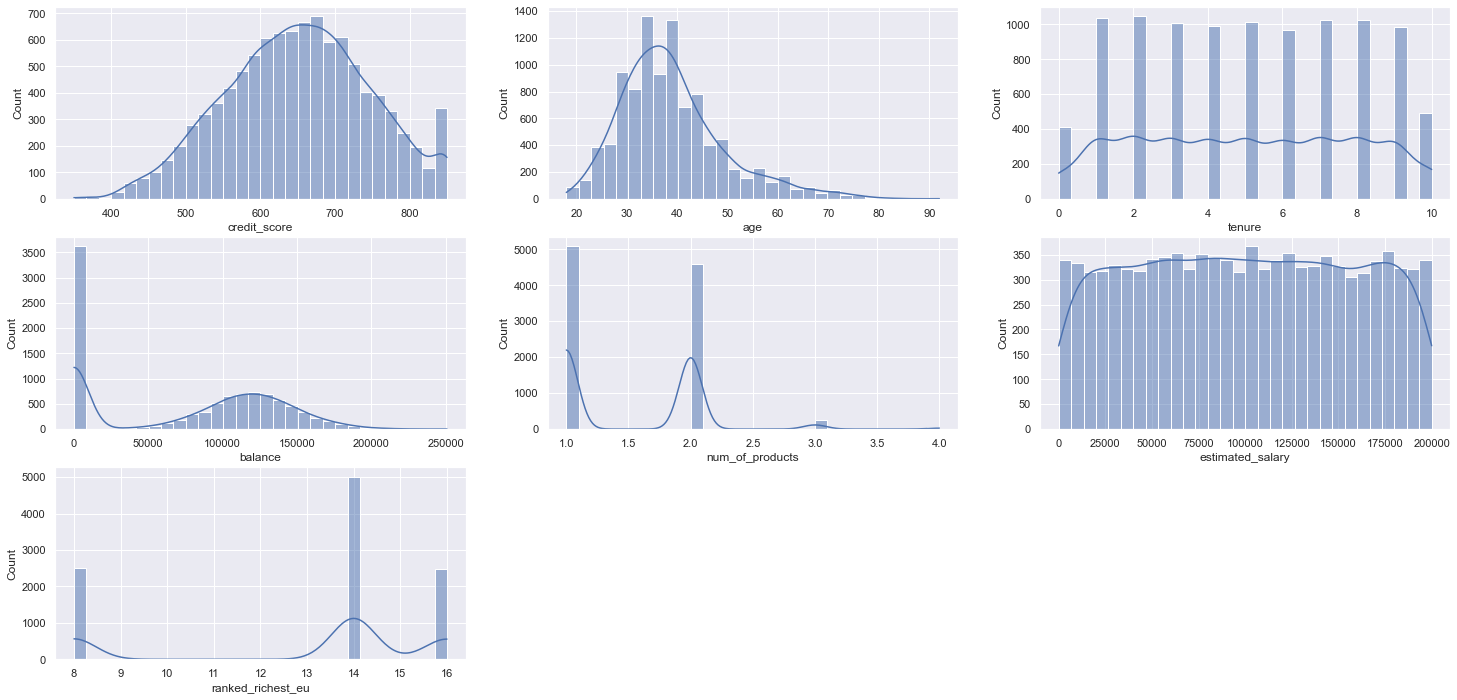

In [29]:
num_attributes = df4.select_dtypes(exclude='object')
columns = num_attributes.columns;
j = 1

for i in columns:
    plt.subplot(3, 3, j)
    sns.histplot(x=i, data=df4, kde=True, bins=30);
    
    j += 1

### 4.1.3 Categorical Variables

In [30]:
df4.dtypes

credit_score           int64
geography             object
gender                object
age                    int64
tenure                 int64
balance              float64
num_of_products        int64
has_cr_card           object
is_active_member      object
estimated_salary     float64
exited                object
life_stage            object
salary                object
pontuation            object
valor                 object
ranked_richest_eu      int64
dtype: object

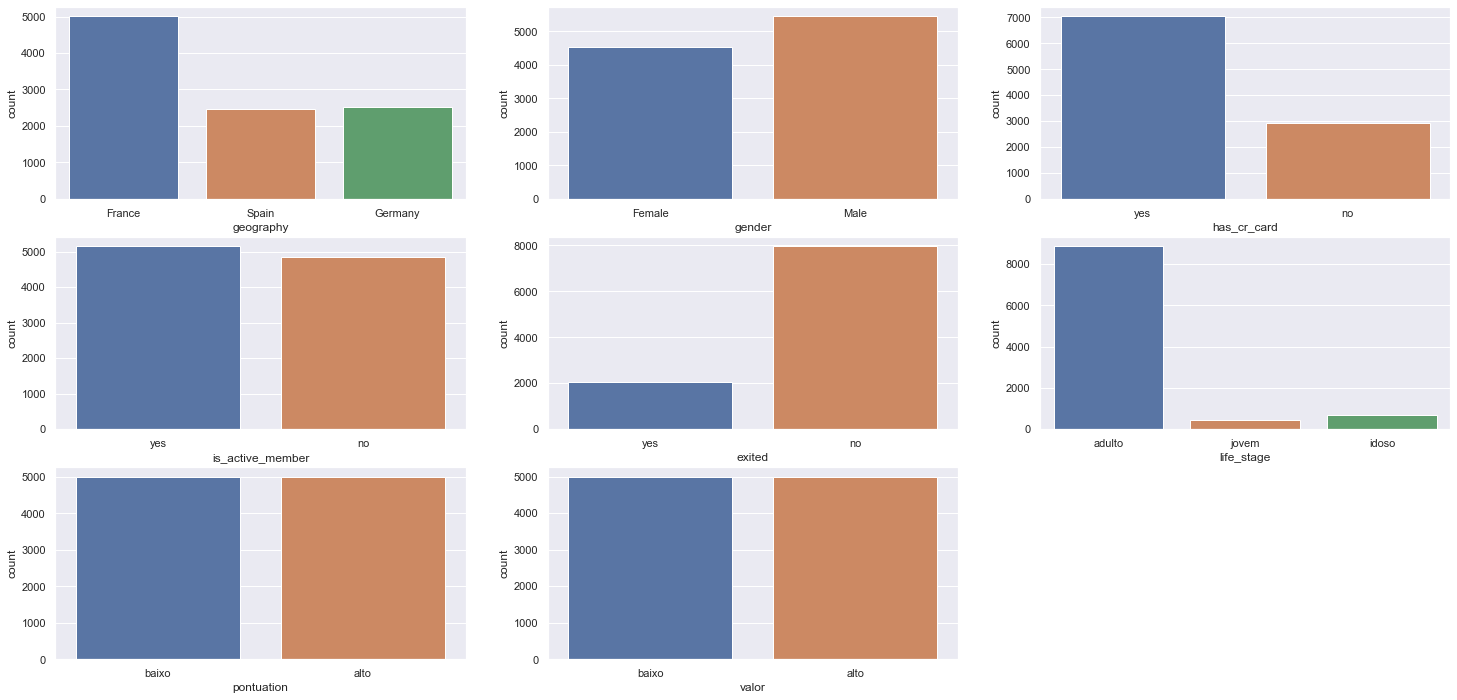

In [31]:
columns = ['geography', 'gender', 'has_cr_card', 'is_active_member', 'exited', "life_stage","pontuation","valor"]
j = 1

for i in columns:
    plt.subplot(3, 3, j)
    sns.countplot(x=i, data=df4);
    j += 1

## 4.2 Bivariate Analysis

### H1. Mulheres desistem mais do que os homens
**VERDADEIRO**

A quantidade de homem é 898 e de mulheres é 1139


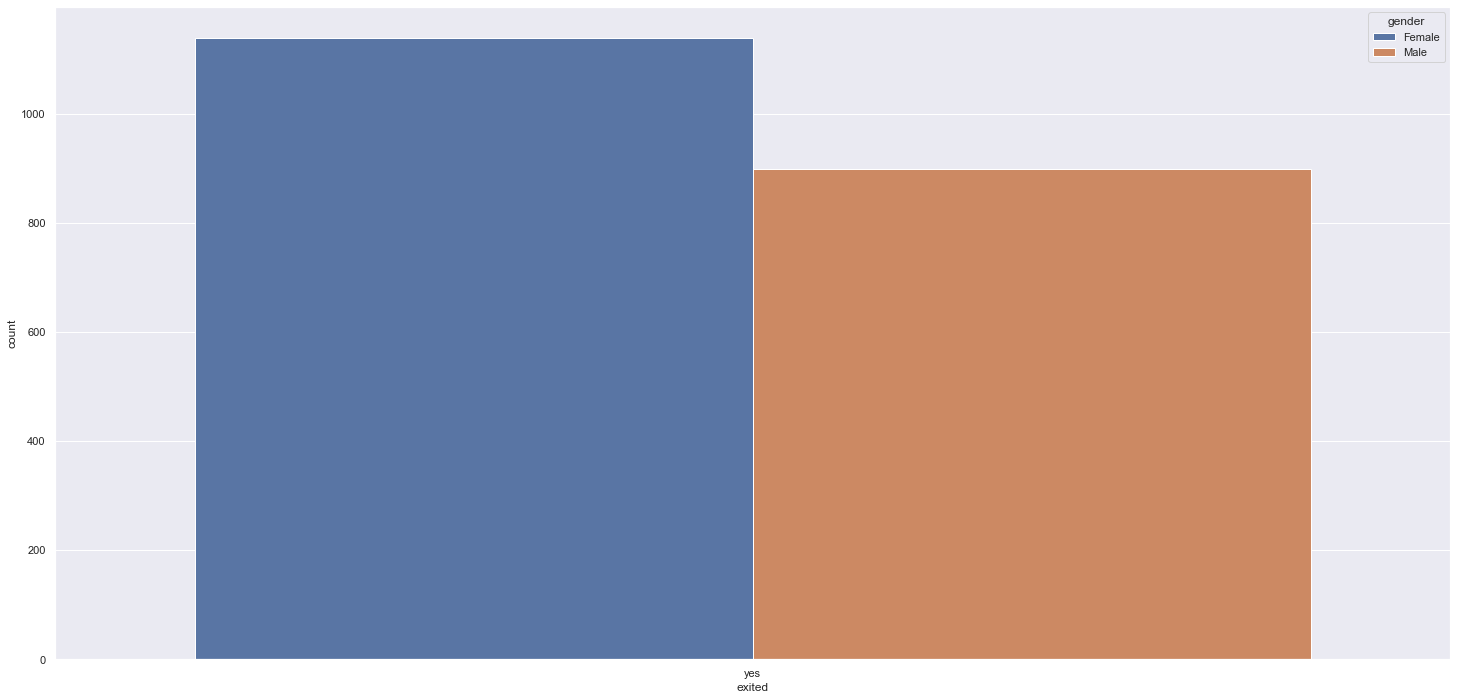

In [32]:
aux = df4[df4["exited"]=="yes"]

women = aux[aux["gender"]=="Female"]
man = aux[aux["gender"]=="Male"]


print(f"A quantidade de homem é {len(man)} e de mulheres é {len(women)}")

sns.countplot(x='exited', hue='gender', data=aux);


Ou seja, mulheres desistem mais rápidos que os homens 

### H2. Temos mais homens ativos do que mulheres
**VERDADEIRO**

A quantidade de homem é 4559 e de mulheres é 3404


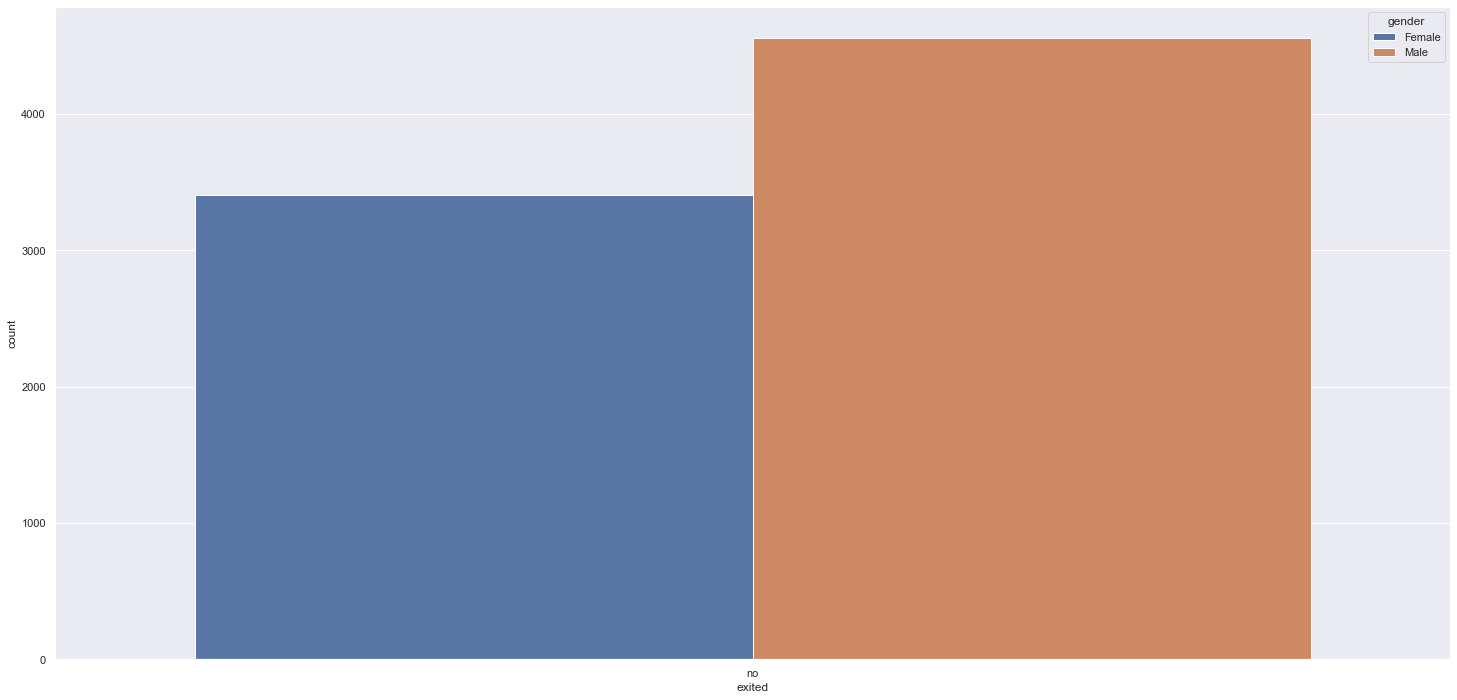

In [33]:
aux = df4[df4["exited"]=="no"]

women = aux[aux["gender"]=="Female"]
man = aux[aux["gender"]=="Male"]


print(f"A quantidade de homem é {len(man)} e de mulheres é {len(women)}")

sns.countplot(x='exited', hue='gender', data=aux);


Temos mais homens ativos atualmente do que mulheres

### H3. Existem mais homens idosos no churn do que Ativos
**FALSO**

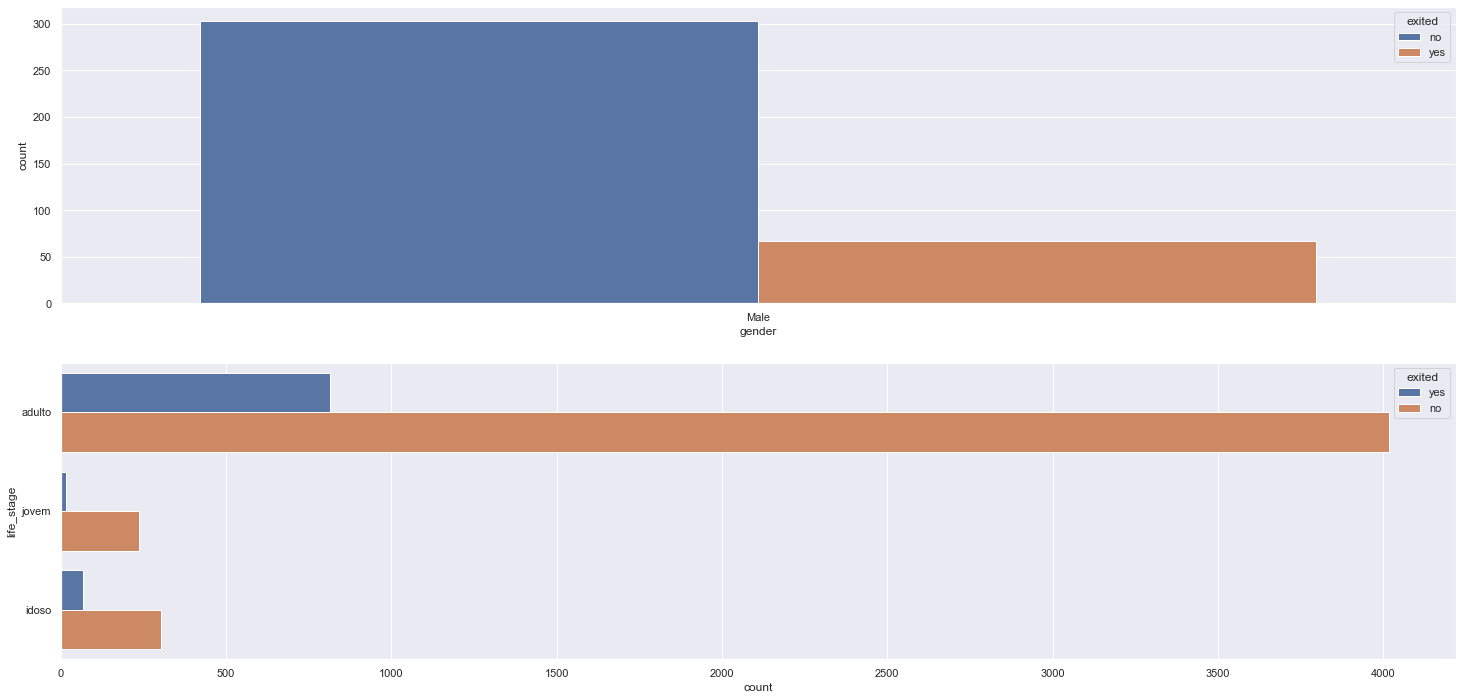

In [34]:
aux = df4[(df4["gender"]=="Male") & (df4["life_stage"]=="idoso") ]
df_aux = df4[(df4["gender"]=="Male") ]

plt.subplot(2, 1, 1)
sns.countplot(x='gender', hue='exited', data=aux);

plt.subplot(2, 1, 2)
sns.countplot(y='life_stage', hue='exited', data=df_aux);

### H4. Homens com salários mais altos tem mais churn

**VERDADEIRO**

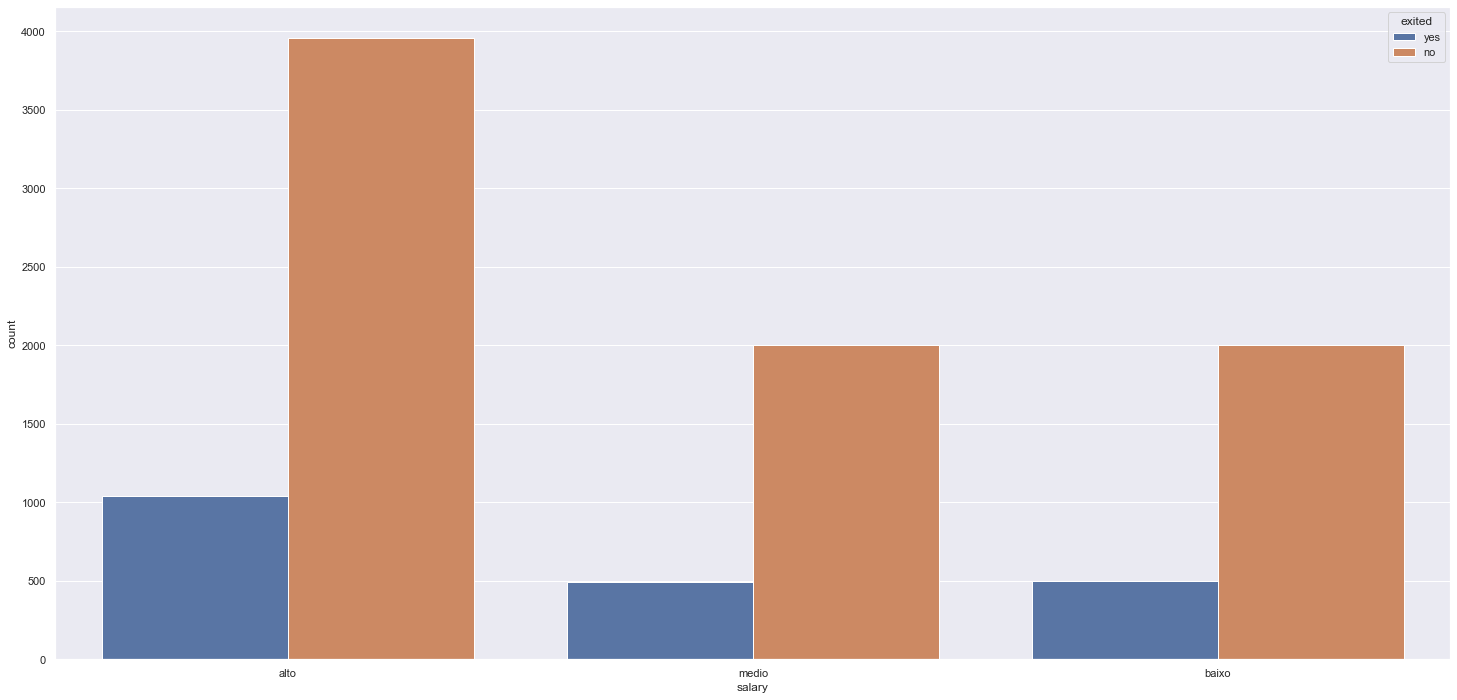

In [35]:
sns.countplot(x='salary', hue='exited', data=df4); 

Verdadeiro homens com maiores salários tem mais churn quando comparado com os médio e baixo

### H5. Clientes ativos ganham salários mais altos na sua maioria 

**VERDADEIRO**

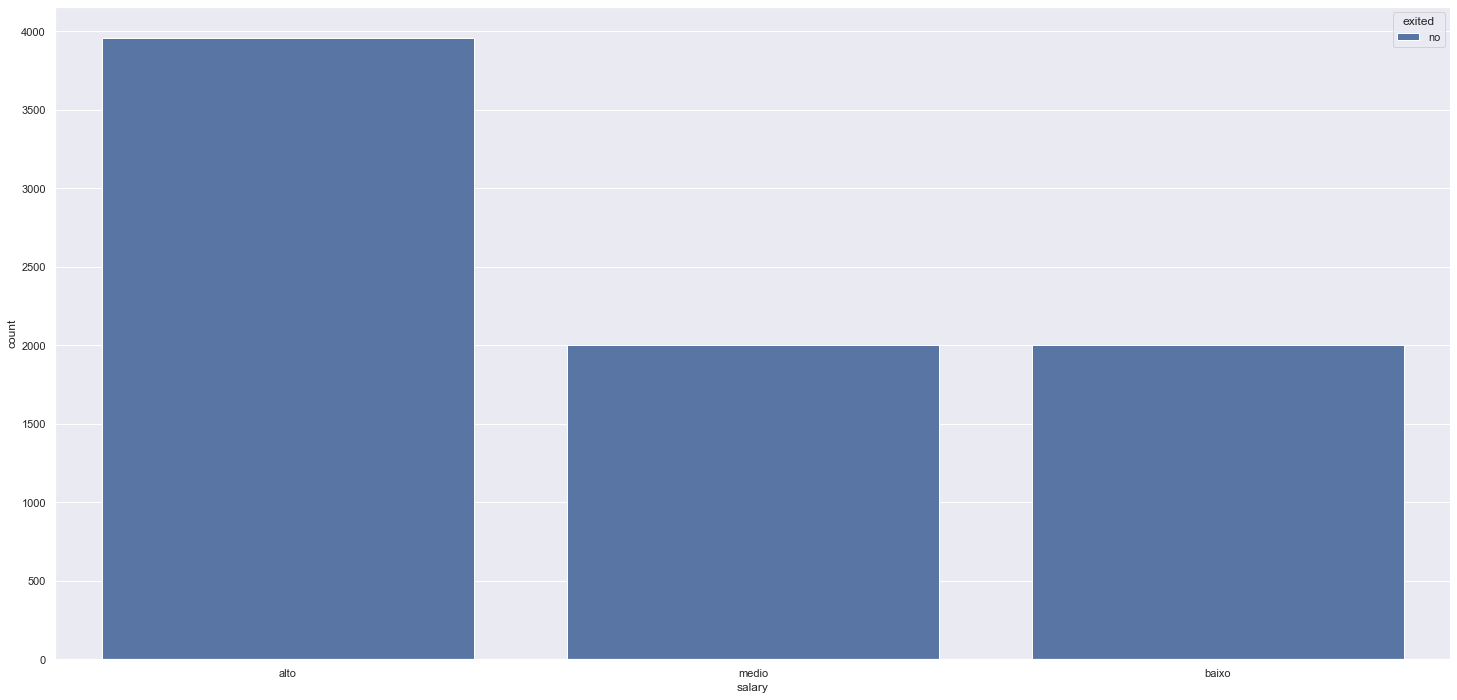

In [36]:
aux = df4[df4["exited"] == "no"]

sns.countplot(x='salary', hue='exited', data=aux); 

### H6. Clientes ativos tem mais pontos no cartão de crédito do que os que entraram em churn

**VERDADEIRO**

Os clientes ativos tem 4050 clientes com a pontuação alta. Já os inativos tem 963 em churn


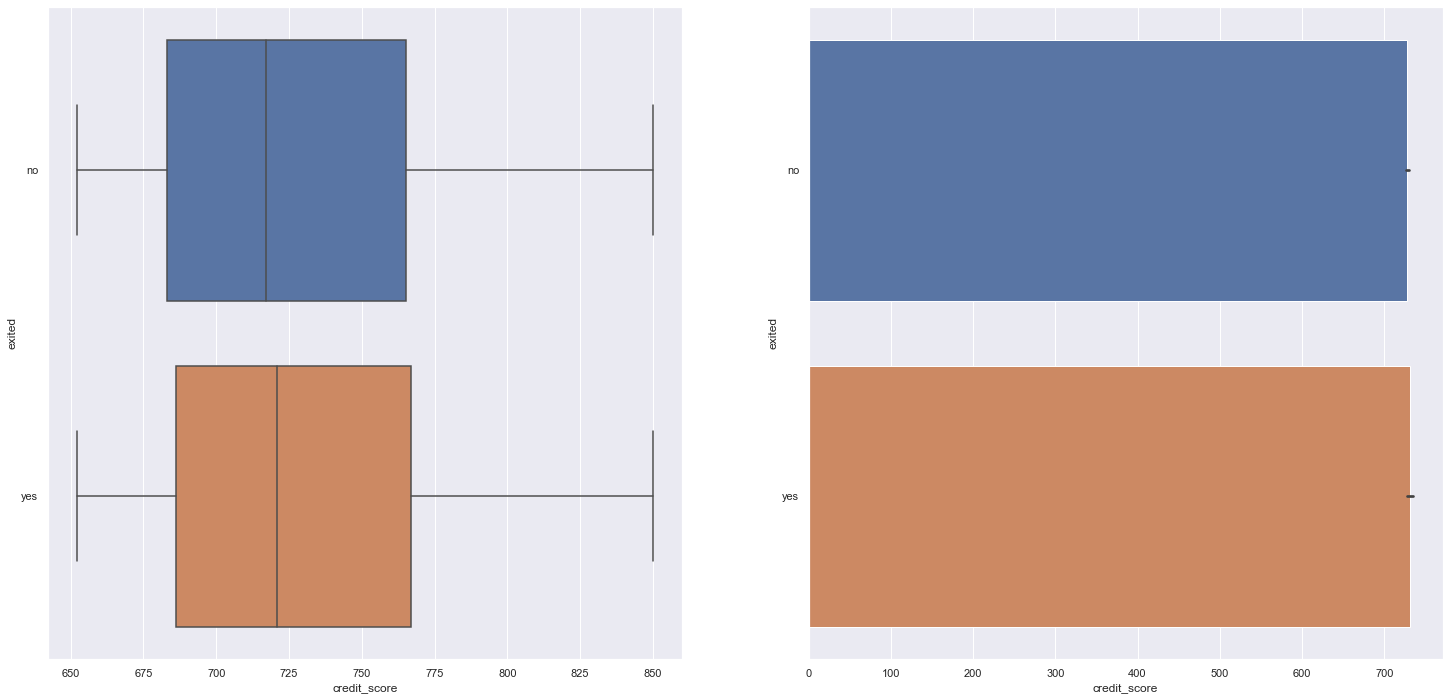

In [37]:
aux = df4[df4["pontuation"]=="alto"]

yes = aux[aux["exited"]=="yes"] 
no = aux[aux["exited"]=="no"] 

print(f"Os clientes ativos tem {len(no)} clientes com a pontuação alta. Já os inativos tem {len(yes)} em churn")

plt.subplot(1, 2, 1)
sns.boxplot(x='credit_score', y='exited', data=aux);

plt.subplot(1, 2, 2)
sns.barplot(x='credit_score', y='exited', data=aux);

### H7. Pessoas ativas compram mais produtos "NumOfProducts" do que as pessoas em churn

**FALSA** Pessoas em churn compram mais produtos variados. Como posso observar no gráfico 4 que somente usuários em churn compraram quantidade 4 de produtos

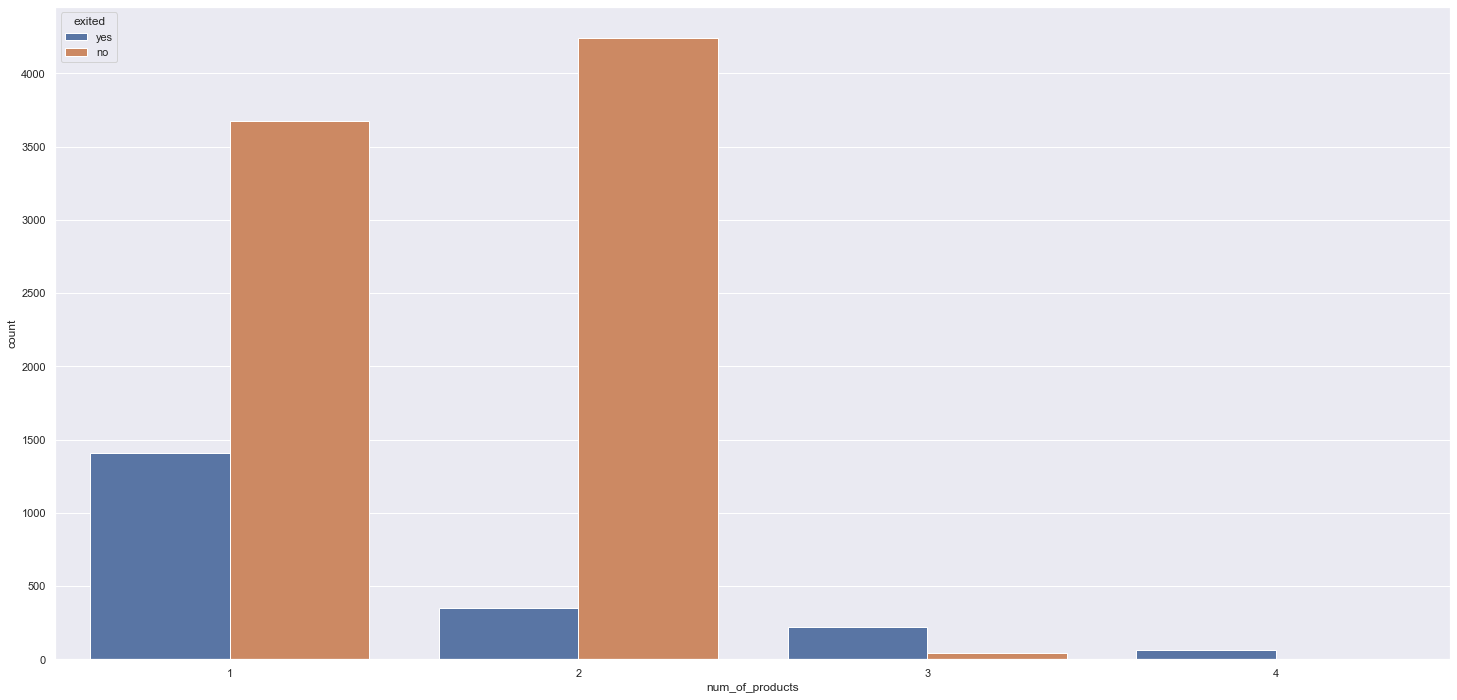

In [38]:
sns.countplot(x='num_of_products', hue='exited', data=df4); 

### H8. Clientes com Balance Alto tem churn mais alto

**FALSO** Tem menos churn

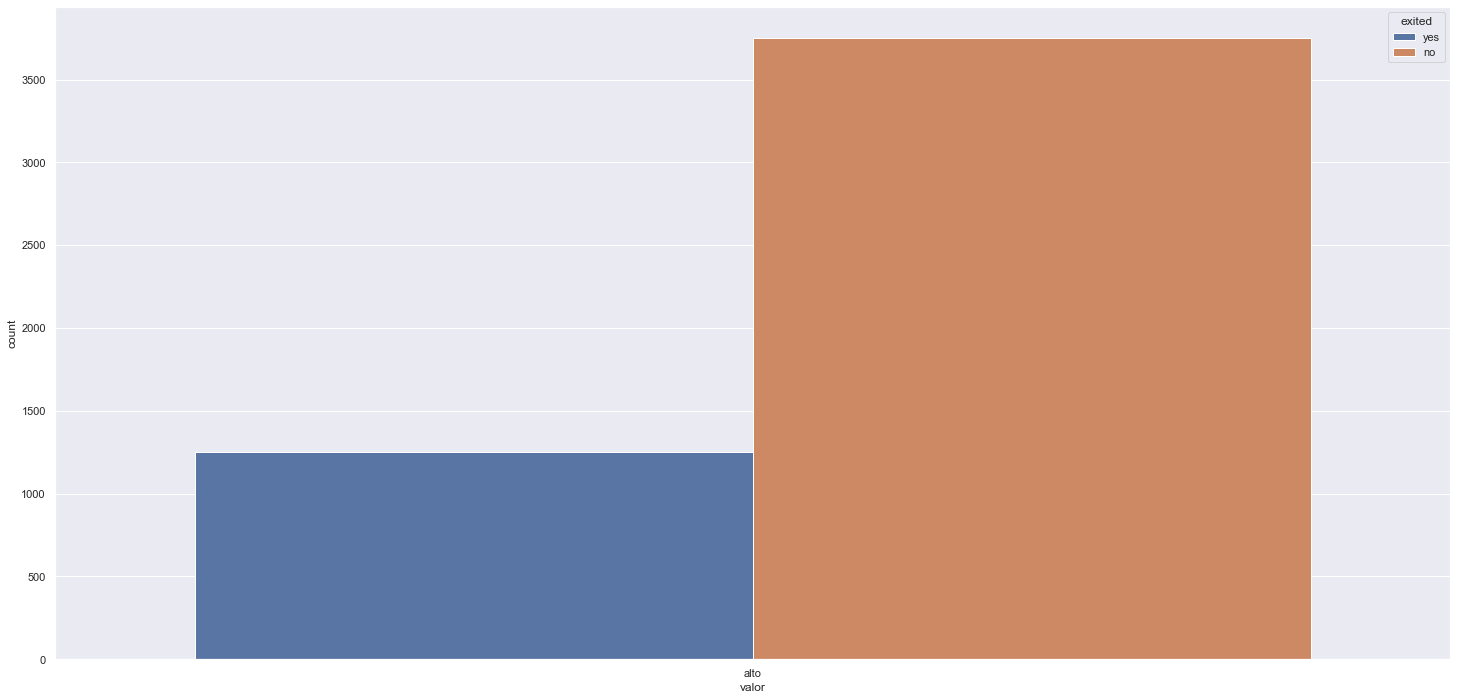

In [39]:
aux = df4[df4["valor"]=="alto"]

sns.countplot(x='valor', hue='exited', data=aux); 

### H9. Pesssoas com Credit Score baixo entram em churn

**FALSO** Temos mais usuários que estão ativos com credit score baixo

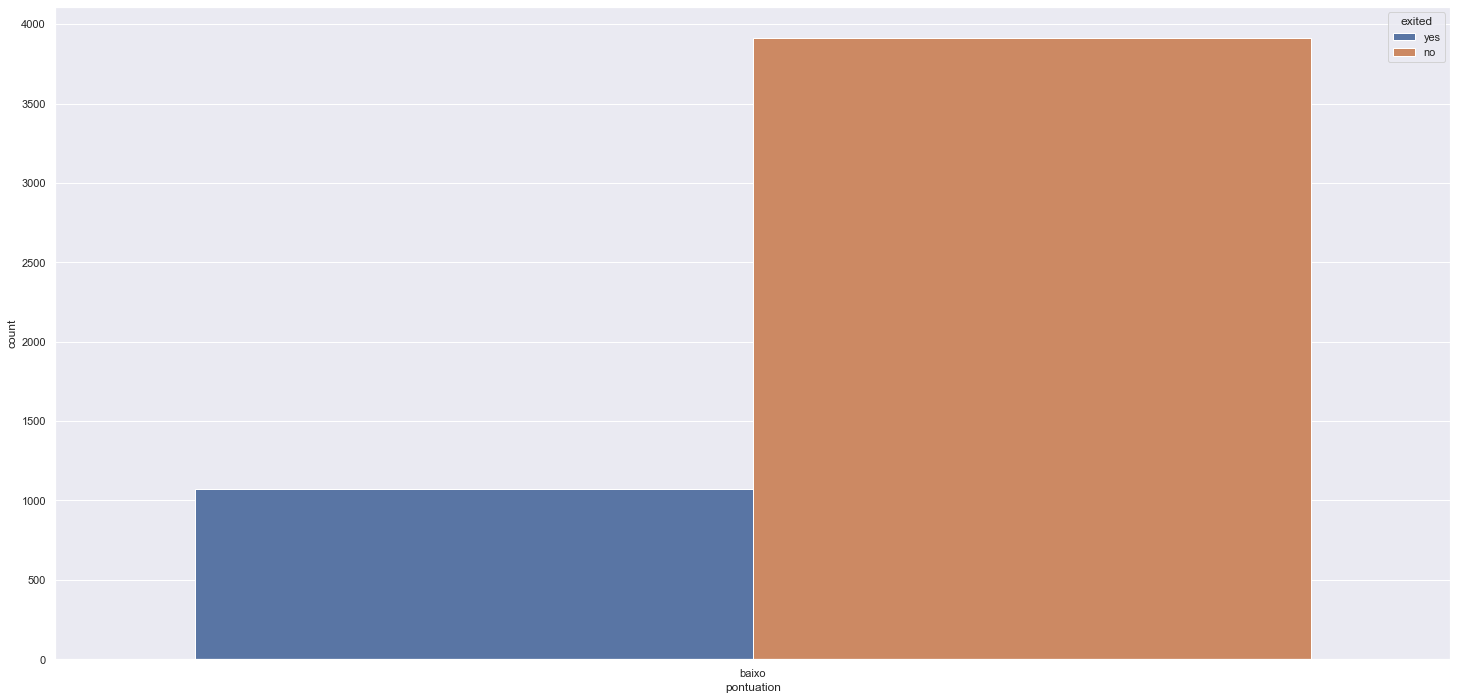

In [40]:
aux = df4[df4["pontuation"]=="baixo"]

sns.countplot(x='pontuation', hue='exited', data=aux); 

### H10. Pessoas com idade mais nova entram jovens do que os idosos e os adultos

**VERDADEIRO** Pessoas mais jovens dificilmente se tornam "CHURN"


Os valores em %: Jovens  - estão em churn 8.75 % , estão ativos 91.25  % 
                 Adultos - estão em churn 20.81 % , estão ativos 79.19 %
                 Idosos  - estão em churn 22.5 %, estão ativos    77.5 %



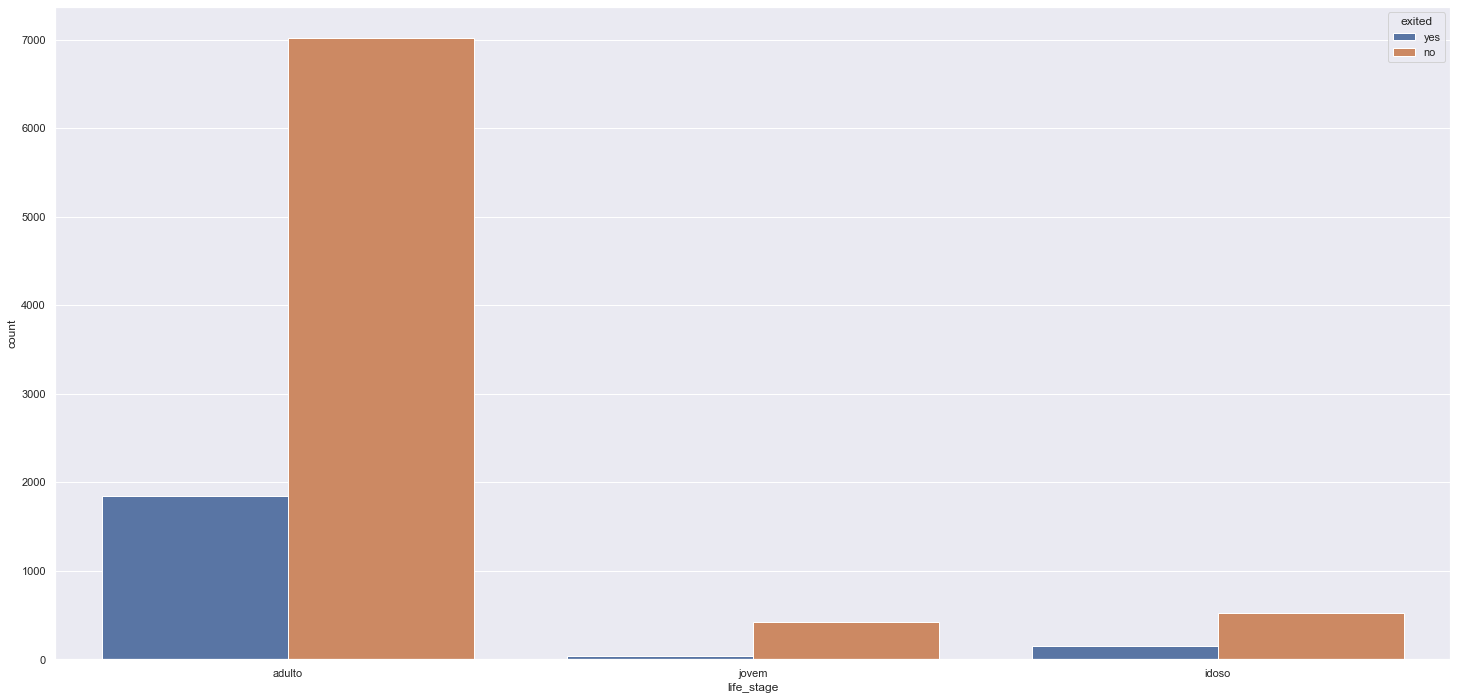

In [41]:
sns.countplot(x='life_stage', hue='exited', data=df4); 

aux_jovem =  df4[df4["life_stage"]=="jovem"]
aux_idoso =  df4[df4["life_stage"]=="idoso"]
aux_adulto = df4[df4["life_stage"]=="adulto"]

jovem_s = aux_jovem[aux_jovem["exited"]=="yes"]
jovem_n = aux_jovem[aux_jovem["exited"]=="no"]

adulto_n = aux_adulto[aux_adulto["exited"]=="no"]
adulto_s = aux_adulto[aux_adulto["exited"]=="yes"]

idoso_n = aux_idoso[aux_idoso["exited"]=="no"]
idoso_s = aux_idoso[aux_idoso["exited"]=="yes"]

print("======================\n")
print(f"""Os valores em %: Jovens  - estão em churn { round(len(jovem_s) / len(aux_jovem) * 100 ,2)} % , estão ativos { round(len(jovem_n) / len(aux_jovem)*100,2)}  % 
                 Adultos - estão em churn { round(len(adulto_s) / len(aux_adulto) * 100 ,2)} % , estão ativos { round(len(adulto_n) / len(aux_adulto) *100,2)} %
                 Idosos  - estão em churn { round(len(idoso_s) / len(aux_idoso)*100,2)} %, estão ativos    { round(len(idoso_n) / len(aux_idoso)*100,2)} %""")
print("======================\n")

##  4.3 Multivariate Analysis


### 4.3.1 Numerical Attributes


In [42]:
aux1 = df4.select_dtypes(exclude='object')
corr = aux1.corr()

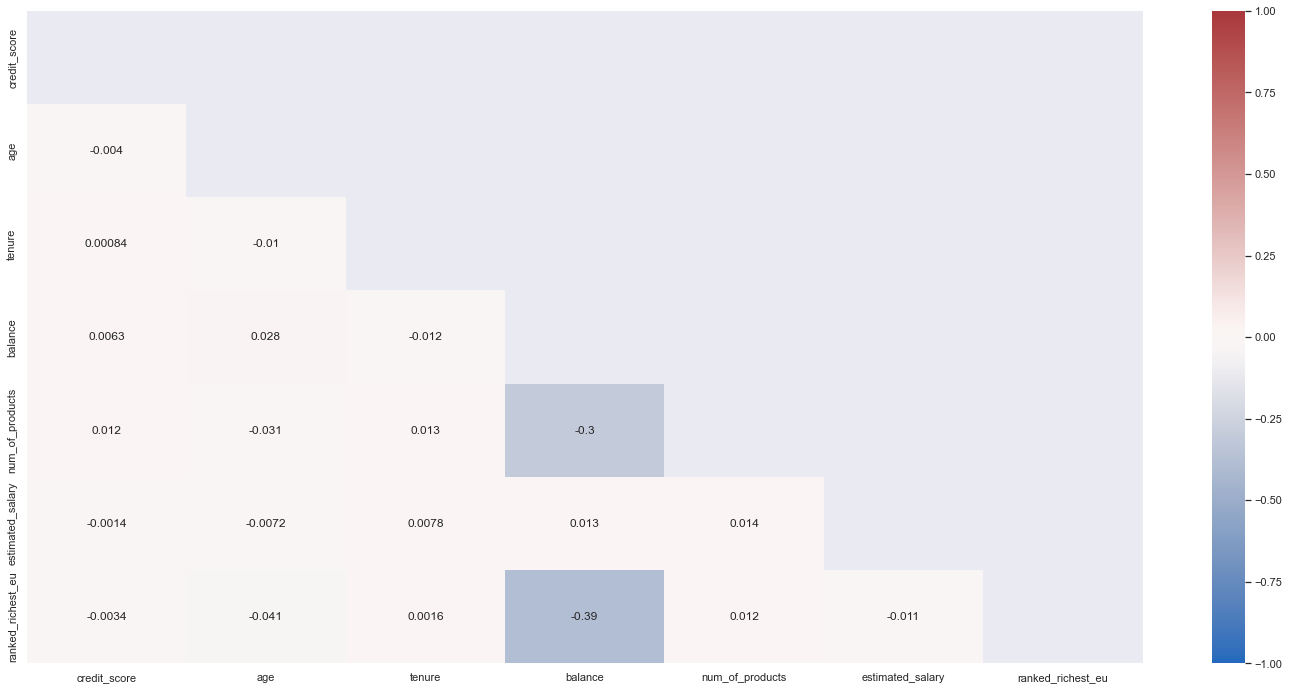

In [43]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("dark"):
    f, ax = plt.subplots()
    ax = sns.heatmap(corr, annot=True, vmax=1, vmin=-1, mask=mask, center=0, cmap="vlag");

Valor monetário que o cliente tem na conta varia inversamente proporcional com a relação de quanto produto comprados pelo cliente

### 4.3.2 Categorical Attributes


In [44]:
aux1 = df4.select_dtypes(include="object") 

corr_dict = {}

for column in aux1.columns.tolist():
    corr_dict[column] = {}
    
    for column2 in aux1.columns.tolist():
        corr_dict[column][column2] = calcCramerV(aux1[column], aux1[column2])
        
corr = pd.DataFrame(corr_dict)

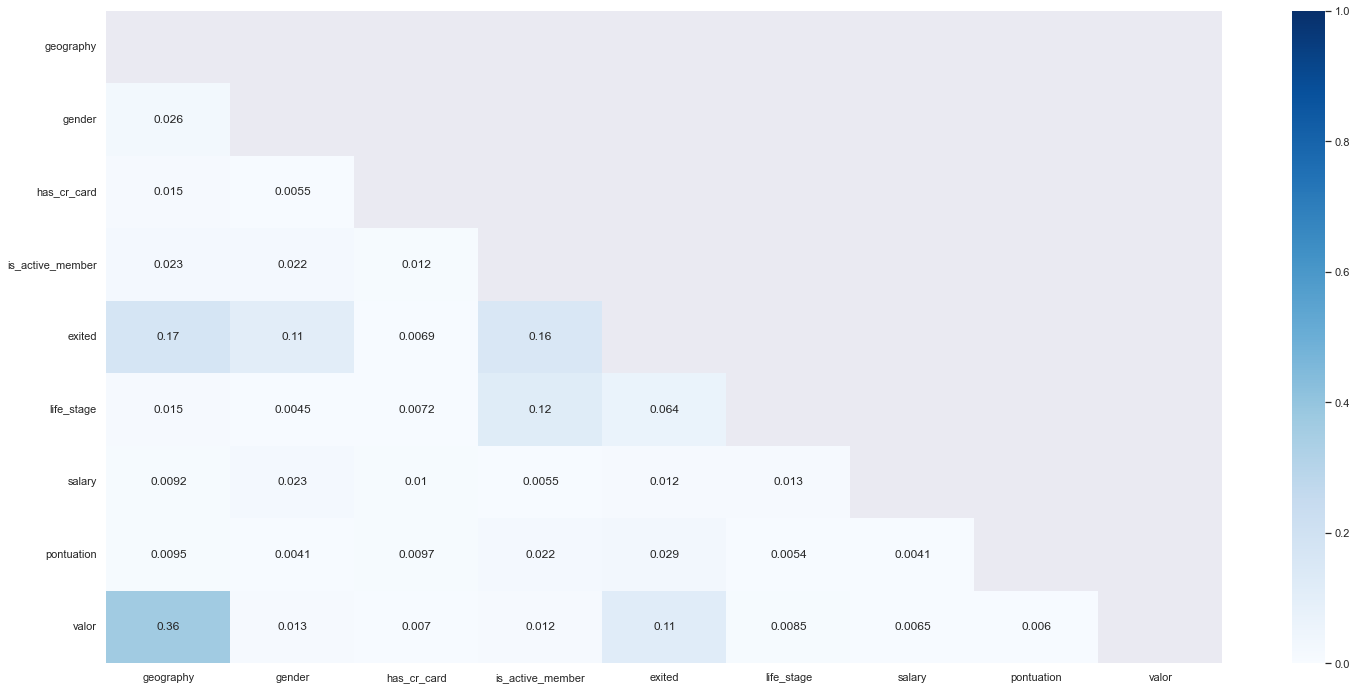

In [45]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("dark"):
    f, ax = plt.subplots()
    ax = sns.heatmap(corr, annot=True, vmin=0, vmax=1, mask=mask, cmap="Blues")

Dados dos países tem uma alta correlação de quanto o usário ganha - correlação de 0.36 <br>
Dados de países tem uma correlação de 0.17 para país onde o usuário reside

# 5.0 Data Preparation

In [46]:
df5 = df4.copy()

In [47]:
df5 = df5.drop(columns=["salary", "pontuation", "valor"])

## 5.1 Spliting into Train, Valid and Test

In [48]:
X = df5.drop(columns=['exited'], axis=1)
y = df5.exited

# enconding into 0 and 1
y = y.map({'yes': 1, 'no': 0})

In [49]:
 # spliting into temp and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=.1, stratify=y)

# spliting into train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=.1, stratify=y_temp)

## 5.2 Target Encoder

In [50]:
target_columns = ['geography', 'gender', 'has_cr_card', 'is_active_member', 'life_stage', 'ranked_richest_eu']
target_encoder = ce.TargetEncoder(cols=target_columns)

In [51]:
X_params = target_encoder.fit_transform(X_temp, y_temp)
X_test = target_encoder.transform(X_test, y_test)

In [52]:
X_train = target_encoder.fit_transform(X_train, y_train)
X_valid = target_encoder.transform(X_valid, y_valid)

## 5.3 Scaling

In [53]:
rescaled_cols = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
mm = MinMaxScaler()

In [54]:
X_params[rescaled_cols] = mm.fit_transform(X_params[rescaled_cols])
X_test[rescaled_cols] = mm.transform(X_test[rescaled_cols])

In [55]:
X_train[rescaled_cols] = mm.fit_transform(X_train[rescaled_cols])
X_valid[rescaled_cols] = mm.transform(X_valid[rescaled_cols])

# 6. Feature Selection

## 6.1 Boruta as Feature Selector


In [56]:
X_boruto = X_params.values
y_boruto = y_temp.values.ravel()

In [57]:
boruta = BorutaPy(RandomForestClassifier(), n_estimators='auto')
boruta.fit(X_boruto, y_boruto)

BorutaPy(estimator=RandomForestClassifier(n_estimators=28,
                                          random_state=RandomState(MT19937) at 0x1E1257D0B40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1E1257D0B40)

### 6.1.1 Best Features from Boruta


In [58]:
cols_selected_boruta = boruta.support_.tolist() 

In [59]:
columns_selected = X_params.loc[:, cols_selected_boruta].columns.tolist() 

In [60]:
columns_selected

['age', 'balance', 'num_of_products']

In [61]:
# ['age', 'balance', 'num_of_products', 'estimated_salary']

# 7.0 Machine Learning Modeling

In [70]:
X_train_selected = X_train[columns_selected]
X_valid_selected = X_valid[columns_selected]

X_temp_selected = X_params[columns_selected]
X_test_selected = X_test[columns_selected]

## 7.1 Baseline Model

In [83]:
dummy = DummyClassifier()
dummy.fit(X_train_selected, y_train)

y_pred = dummy.predict(X_valid_selected)

In [84]:
dummy_results = ml_scores('dummy', y_valid, y_pred)
dummy_results

C:\Users\guisg\anaconda3\envs\pythonProject\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.5,0.0,0.0,0.0,0.0


### 7.1.1 Classification Report


In [85]:
print(m.classification_report(y_valid, y_pred)) 

              precision    recall  f1-score   support

           0       0.80      1.00      0.89       717
           1       0.00      0.00      0.00       183

    accuracy                           0.80       900
   macro avg       0.40      0.50      0.44       900
weighted avg       0.63      0.80      0.71       900



C:\Users\guisg\anaconda3\envs\pythonProject\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\guisg\anaconda3\envs\pythonProject\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\guisg\anaconda3\envs\pythonProject\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

### 7.1.2 Cross Validation

In [86]:
dummy_cv = ml_cv_results('dummy', DummyClassifier(), X_temp_selected, y_temp)
dummy_cv

C:\Users\guisg\anaconda3\envs\pythonProject\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\guisg\anaconda3\envs\pythonProject\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\guisg\anaconda3\envs\pythonProject\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\guisg\anaconda3\envs\pythonProject\lib\site-packages

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0


## 7.2 Logistic Regression

In [87]:
lg = LogisticRegression()
lg.fit(X_train_selected, y_train)

y_pred = lg.predict(X_valid_selected)

In [88]:
lg_results = ml_scores('Logistic Regression', y_valid, y_pred)
lg_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.528,0.455,0.082,0.139,0.082


### 7.2.1 Classification Report

In [90]:
print(m.classification_report(y_valid, y_pred)) 

              precision    recall  f1-score   support

           0       0.81      0.97      0.88       717
           1       0.45      0.08      0.14       183

    accuracy                           0.79       900
   macro avg       0.63      0.53      0.51       900
weighted avg       0.73      0.79      0.73       900



### 7.2.2 Cross Validation


In [91]:
lg_cv = ml_cv_results('Logistic Regression', LogisticRegression(), X_temp_selected, y_temp)
lg_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.512 +/- 0.006,0.306 +/- 0.049,0.058 +/- 0.012,0.098 +/- 0.019,0.035 +/- 0.016


## 7.3 K Nearest Neighbors

In [92]:
knn = KNeighborsClassifier()
knn.fit(X_train_selected, y_train)

y_pred = knn.predict(X_valid_selected)

In [93]:
 knn_results = ml_scores('K Nearest Neighbors', y_valid, y_pred)
knn_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.666,0.683,0.377,0.486,0.399


### 7.3.1 Classification Report

In [94]:
print(m.classification_report(y_valid, y_pred)) 

              precision    recall  f1-score   support

           0       0.86      0.96      0.90       717
           1       0.68      0.38      0.49       183

    accuracy                           0.84       900
   macro avg       0.77      0.67      0.69       900
weighted avg       0.82      0.84      0.82       900



### 7.3.2 Cross Validation

In [95]:
knn_cv = ml_cv_results('K Nearest Neighbors', KNeighborsClassifier(), X_temp_selected, y_temp)
knn_cv 

,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.676 +/- 0.012,0.616 +/- 0.032,0.418 +/- 0.022,0.498 +/- 0.021,0.399 +/- 0.026


## 7.4 Support Vector Machine


In [96]:
svm = SVC()
svm.fit(X_train_selected, y_train)

y_pred = svm.predict(X_valid_selected)

In [97]:
svm_results = ml_scores('SVM', y_valid, y_pred)
svm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.607,0.741,0.235,0.357,0.287


### 7.4.1 Classification Support

In [98]:
print(m.classification_report(y_valid, y_pred)) 

              precision    recall  f1-score   support

           0       0.83      0.98      0.90       717
           1       0.74      0.23      0.36       183

    accuracy                           0.83       900
   macro avg       0.79      0.61      0.63       900
weighted avg       0.81      0.83      0.79       900



### 7.4.2 Cross Validation

In [99]:
svm_cv = ml_cv_results('SVM', SVC(), X_temp_selected, y_temp)
svm_cv 

,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.637 +/- 0.015,0.713 +/- 0.022,0.307 +/- 0.037,0.427 +/- 0.033,0.347 +/- 0.028


## 7.5 Random Forest

In [100]:
rf = RandomForestClassifier()
rf.fit(X_train_selected, y_train)

y_pred = rf.predict(X_valid_selected)

In [101]:
rf_results = ml_scores('Random Forest', y_valid, y_pred)
rf_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.677,0.525,0.459,0.49,0.37


### 7.5.1 Classification Support


In [102]:
print(m.classification_report(y_valid, y_pred)) 

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       717
           1       0.53      0.46      0.49       183

    accuracy                           0.81       900
   macro avg       0.70      0.68      0.68       900
weighted avg       0.80      0.81      0.80       900



### 7.5.2 Cross Validation


In [104]:
rf_cv = ml_cv_results('Random Forest', RandomForestClassifier(), X_temp_selected, y_temp)
rf_cv 

,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.669 +/- 0.016,0.521 +/- 0.025,0.442 +/- 0.034,0.477 +/- 0.026,0.357 +/- 0.029


## 7.6 XGBoost


In [106]:
xgb = XGBClassifier()
xgb.fit(X_train_selected, y_train)

y_pred = xgb.predict(X_valid_selected)

[12:23:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [107]:
xgb_results = ml_scores('XGBoost', y_valid, y_pred)
xgb_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.662,0.645,0.377,0.476,0.383


### 7.6.1 Classification Report


In [108]:
print(m.classification_report(y_valid, y_pred)) 

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       717
           1       0.64      0.38      0.48       183

    accuracy                           0.83       900
   macro avg       0.75      0.66      0.69       900
weighted avg       0.81      0.83      0.81       900



### 7.6.2 Cross Validation


In [109]:
xgb_cv = ml_cv_results('XGBoost', XGBClassifier(), X_temp_selected, y_temp)
xgb_cv

C:\Users\guisg\anaconda3\envs\pythonProject\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:24:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\guisg\anaconda3\envs\pythonProject\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:24:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\guisg\anaconda3\envs\pythonProject\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:24:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\guisg\anaconda3\envs\pythonProject\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:24:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\guisg\anaconda3\envs\pythonProject\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:24:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.67 +/- 0.005,0.629 +/- 0.018,0.402 +/- 0.01,0.49 +/- 0.011,0.394 +/- 0.013


## 7.7 LightGBM


In [110]:
lgbm = LGBMClassifier()
lgbm.fit(X_train_selected, y_train)

y_pred = xgb.predict(X_valid_selected)

In [111]:
lgbm_results = ml_scores('LightGBM', y_valid, y_pred)
lgbm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
LightGBM,0.662,0.645,0.377,0.476,0.383


### 7.7.1 Classification Report


In [112]:
print(m.classification_report(y_valid, y_pred)) 

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       717
           1       0.64      0.38      0.48       183

    accuracy                           0.83       900
   macro avg       0.75      0.66      0.69       900
weighted avg       0.81      0.83      0.81       900



### 7.7.2 Cross Validation


In [113]:
lgbm_cv = ml_cv_results('LightGBM', LGBMClassifier(), X_temp_selected, y_temp)
lgbm_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
LightGBM,0.675 +/- 0.017,0.663 +/- 0.031,0.402 +/- 0.037,0.499 +/- 0.031,0.409 +/- 0.032


## 7.8 Comparing Model's Performance

### 7.8.1 Single Performance


In [115]:
modeling_performance = pd.concat([dummy_results, lg_results, knn_results, 
                                  rf_results, xgb_results, lgbm_results])
modeling_performance.sort_values(by="Recall", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.500,0.000,0.000,0.000,0.000
Logistic Regression,0.528,0.455,0.082,0.139,0.082
K Nearest Neighbors,0.666,0.683,0.377,0.486,0.399
XGBoost,0.662,0.645,0.377,0.476,0.383
LightGBM,0.662,0.645,0.377,0.476,0.383
Random Forest,0.677,0.525,0.459,0.490,0.370


### 7.8.2 Cross Validation Peformance


In [116]:
modeling_performance_cv = pd.concat([dummy_cv, lg_cv, knn_cv, 
                                     rf_cv, xgb_cv, lgbm_cv])
modeling_performance_cv.sort_values(by="Recall", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0
Logistic Regression,0.512 +/- 0.006,0.306 +/- 0.049,0.058 +/- 0.012,0.098 +/- 0.019,0.035 +/- 0.016
XGBoost,0.67 +/- 0.005,0.629 +/- 0.018,0.402 +/- 0.01,0.49 +/- 0.011,0.394 +/- 0.013
LightGBM,0.675 +/- 0.017,0.663 +/- 0.031,0.402 +/- 0.037,0.499 +/- 0.031,0.409 +/- 0.032
K Nearest Neighbors,0.676 +/- 0.012,0.616 +/- 0.032,0.418 +/- 0.022,0.498 +/- 0.021,0.399 +/- 0.026
Random Forest,0.669 +/- 0.016,0.521 +/- 0.025,0.442 +/- 0.034,0.477 +/- 0.026,0.357 +/- 0.029
